In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/DL_project/data.zip" "."

In [ ]:
!unzip -uq "data.zip"

# Import libraries

In [ ]:
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import IPython.display as ipd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb=100"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Data preprocessing

In [ ]:
# Define the alpha function for RSB calculation
def calculate_alpha(RSB):
    return 10 ** (-RSB / 20)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, clean_audio_dir, noise_path, start_files=0, end_files=100):
        self.clean_audio_files = []
        self.noisy_audio_files = []
        self.clean_audio_dir = glob.glob(clean_audio_dir, recursive=False)[start_files:end_files]
        
        # Load the clean audio files
        self.clean_audio_files = [librosa.load(file, sr=16000)[0] for file in self.clean_audio_dir]
        
        # Load the noise file
        noise, _ = librosa.load(noise_path, sr=None)
        
        # Generate random RSB values
        rsb_values = np.random.randint(-10, 11, len(self.clean_audio_files))

        # Add noise to the clean audio files
        self.noisy_audio_files = [self.clean_audio_files[i] + noise[:len(self.clean_audio_files[i])] * calculate_alpha(rsb_values[i]) for i in range(len(self.clean_audio_files))]

        # Convert audio files to STFT and to PyTorch tensors
        self.clean_audio_files = [torch.tensor(np.transpose(np.abs(librosa.stft(file, n_fft=1024, hop_length=512)))).cuda() for file in self.clean_audio_files]
        self.noisy_audio_files = [torch.tensor(np.transpose(np.abs(librosa.stft(file, n_fft=1024, hop_length=512)))).cuda() for file in self.noisy_audio_files]

        # Get the minimum shape of the clean audio files
        pad_shape = min([file.shape[0] for file in self.clean_audio_files])

        # Pad the clean and noisy audio files with zeros
        for i in range(len(self.clean_audio_files)):
            diff_pad = pad_shape - self.clean_audio_files[i].shape[0]
            self.clean_audio_files[i] = F.pad(self.clean_audio_files[i], (0, 0, diff_pad, 0))
            self.noisy_audio_files[i] = F.pad(self.noisy_audio_files[i], (0, 0, diff_pad, 0))

    def __len__(self):
        return len(self.noisy_audio_files)

    def __getitem__(self, idx):
        return (self.noisy_audio_files[idx], self.clean_audio_files[idx])

In [ ]:
# Create a DataLoader for the dataset
dataset = AudioDataset("data/LibriSpeech/dev-clean/**/**/*.flac", "data/noise/babble.wav", end_files=2300)
train_loader = DataLoader(dataset, batch_size=100)

# Build model architecture

In [ ]:
# Define a neural network for audio denoising
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(513, 2048)
        self.hidden_layer1 = nn.Linear(2048, 1024)
        self.hidden_layer2 = nn.Linear(1024, 1024)
        self.hidden_layer3 = nn.Linear(1024, 2048)
        self.output_layer = nn.Linear(2048, 513)
        self.activation = nn.ReLU()

    def forward(self, data):
        data = data.view(-1, 513).cuda()
        output = self.activation(self.input_layer(data))
        output = self.activation(self.hidden_layer1(output))
        output = self.activation(self.hidden_layer2(output))
        output = self.activation(self.hidden_layer3(output))
        output_layer = self.output_layer(output)
        final = torch.nn.functional.relu(output_layer)
        return final

# Train the model

In [ ]:
# Initialize the neural network and move it to the GPU
neural_network = NeuralNet().cuda()
summary(neural_network, input_size=(513,2048))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       1,052,672
              ReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
              ReLU-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 2048]       2,099,200
              ReLU-8                 [-1, 2048]               0
            Linear-9                  [-1, 513]       1,051,137
Total params: 7,350,785
Trainable params: 7,350,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.01
Forward/backward pass size (MB): 0.10
Params size (MB): 28.04
Estimated Total Size (MB): 32.15
-------------------------------------

In [ ]:
# Set fixed random number seed
torch.manual_seed(42)

# Define the loss function and optimizer
num_epochs = 100
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)
loss_list = []

# Train the neural network
for epoch in range(num_epochs):
    for i, (noisy, clean) in enumerate(train_loader):
        # Forward pass
        outputs = neural_network(noisy.cuda())
        # print(outputs.shape, clean.shape)
        # clean = clean.squeeze(0)
        outputs = outputs.reshape(clean.shape)
        # Calculate the loss
        loss = criterion(outputs, clean.cuda())

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    loss_list.append(loss.data.cpu().numpy())

torch.save(neural_network.state_dict(), 'model_epoch_'+str(epoch)+'.pth')
print('Training complete')
print(loss.data)

Epoch [1/100], Loss: 0.5509
Epoch [2/100], Loss: 0.5193
Epoch [3/100], Loss: 0.5193
Epoch [4/100], Loss: 0.4940
Epoch [5/100], Loss: 0.4818
Epoch [6/100], Loss: 0.4797
Epoch [7/100], Loss: 0.4395
Epoch [8/100], Loss: 0.4231
Epoch [9/100], Loss: 0.4119
Epoch [10/100], Loss: 0.3865
Epoch [11/100], Loss: 0.3796
Epoch [12/100], Loss: 0.3475
Epoch [13/100], Loss: 0.3521
Epoch [14/100], Loss: 0.3349
Epoch [15/100], Loss: 0.3397
Epoch [16/100], Loss: 0.3171
Epoch [17/100], Loss: 0.3205
Epoch [18/100], Loss: 0.3036
Epoch [19/100], Loss: 0.3089
Epoch [20/100], Loss: 0.2942
Epoch [21/100], Loss: 0.3027
Epoch [22/100], Loss: 0.2934
Epoch [23/100], Loss: 0.2835
Epoch [24/100], Loss: 0.2892
Epoch [25/100], Loss: 0.2773
Epoch [26/100], Loss: 0.2749
Epoch [27/100], Loss: 0.2654
Epoch [28/100], Loss: 0.2597
Epoch [29/100], Loss: 0.2552
Epoch [30/100], Loss: 0.2576
Epoch [31/100], Loss: 0.2577
Epoch [32/100], Loss: 0.2570
Epoch [33/100], Loss: 0.2574
Epoch [34/100], Loss: 0.2559
Epoch [35/100], Loss: 0

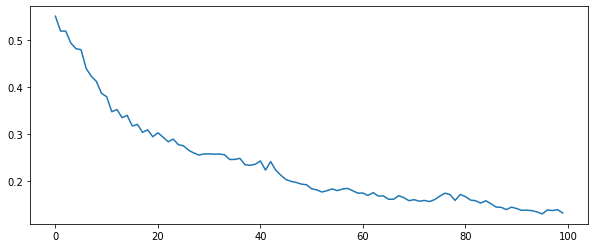

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(range(num_epochs), loss_list)
plt.show()

# Model Evaluation

In [ ]:
def test(neural_network, test_loader, criterion):
    # Set the model to eval mode
    neural_network.eval()

    # Initialize variables to store the total loss, MSE, MAE and R2 score
    total_loss = 0
    mse = 0
    mae = 0
    r2 = 0
    snr = 0
    total_samples = 0
    with torch.no_grad():
        for i, (noisy, clean) in enumerate(test_loader):
            # Forward pass
            outputs = neural_network(noisy)
            # Calculate the loss
            outputs = outputs.reshape(clean.shape)
            loss = criterion(outputs, clean)
            total_loss += loss.item() * len(noisy)
            total_samples += len(noisy)
            mse += mean_squared_error(clean.flatten().cpu().numpy(), outputs.flatten().cpu().numpy())
            mae += mean_absolute_error(clean.flatten().cpu().numpy(), outputs.flatten().cpu().numpy())
            r2 += r2_score(clean.flatten().cpu().numpy(), outputs.flatten().cpu().numpy())

            # Calculate the signal-to-noise ratio (SNR)
            clean_energy = np.sum(clean.flatten().cpu().numpy() ** 2)
            noise_energy = np.sum((outputs - clean).flatten().cpu().numpy() ** 2)
            snr += 10 * np.log10(clean_energy / noise_energy)

    # Calculate the average loss
    avg_loss = total_loss / total_samples
    avg_mse = mse / total_samples
    avg_mae = mae / total_samples
    avg_r2 = r2 / total_samples
    avg_snr = snr / total_samples
    # Print the results
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test MSE: {avg_mse:.4f}')
    print(f'Test MAE: {avg_mae:.4f}')
    print(f'Test R2 score: {avg_r2:.4f}')
    print(f'Test SNR: {avg_snr:.4f} dB')
    # return avg_loss, avg_mse, avg_mae, avg_r2

# Create a DataLoader for the test dataset
test_dataset = AudioDataset("data/LibriSpeech/dev-clean/**/**/*.flac", "data/noise/babble.wav", start_files=2300, end_files=2700)
test_loader = DataLoader(test_dataset)

# Test the trained model
test(neural_network, test_loader, criterion)

Test Loss: 0.1626
Test MSE: 0.1626
Test MAE: 0.1185
Test R2 score: 0.7196
Test SNR: 6.5646 dB


In this code, I've added a test function that takes in the trained neural network, a test data loader and the criterion used for training. The function sets the model to eval mode, initializes the total loss and number of samples to zero, then iterates through the test data, calculates the loss for each batch and accumulates it. After the loop, it calculates the average loss by dividing the total loss by the number of samples. Finally, it prints the average loss on the test dataset. I've also added the test dataset and test data loader.

# Test audio

In [ ]:
# common function for testing the audio files
def test_audio(input_file_path, output_file_path):
    s, sr=librosa.load(input_file_path, sr=None)
    test = librosa.stft(s, n_fft=1024, hop_length=512)
    test_tensor = np.transpose(torch.tensor(np.abs(test)))
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=test_tensor.shape[0])
    t_iter = iter(test_loader)
    with torch.no_grad():
        while True:
            try:
                data = next(t_iter)
                data = data.cuda()
                output = neural_network(data)
            except StopIteration:
                break 
        spec = (test / np.abs(test)) * output.cpu().numpy().T
        # spec = test * output.cpu().numpy().T/2
        spec_istft = librosa.istft(spec, hop_length=512)
        sf.write(output_file_path, spec_istft, sr)

In [ ]:
ipd.Audio('data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac')

In [ ]:
x_clean, sr = librosa.load("data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac", sr=None)
noise, _ = librosa.load("data/noise/babble.wav")
x_noisy = x_clean + noise[:len(x_clean)] * calculate_alpha(4)
sf.write("test.wav", x_noisy, sr)

In [ ]:
ipd.Audio("test.wav")

In [ ]:
# testing on the audio 1
test_audio('test.wav', 'test_s_01_recons.wav')
ipd.Audio('test_s_01_recons.wav')

In [ ]:
# x_clean, sr = librosa.load("data/LibriSpeech/dev-clean/8842/302201/8842-302201-0000.flac", sr=None)
# x_noisy = x_clean + noise[:len(x_clean)] * calculate_alpha(4)
# sf.write("test.wav", x_noisy, sr)
# # testing on the audio 2
# test_audio('test.wav', 'test_s_02_recons.wav')
# ipd.Audio('test_s_02_recons.wav')

In [ ]:
clean_audio_dir = glob.glob("data/LibriSpeech/dev-clean/**/**/*.flac", recursive=False)[2700:2703]
clean_audio_dir

['data/LibriSpeech/dev-clean/8842/302201/8842-302201-0013.flac',
 'data/LibriSpeech/dev-clean/8842/302201/8842-302201-0001.flac',
 'data/LibriSpeech/dev-clean/8842/302201/8842-302201-0000.flac']

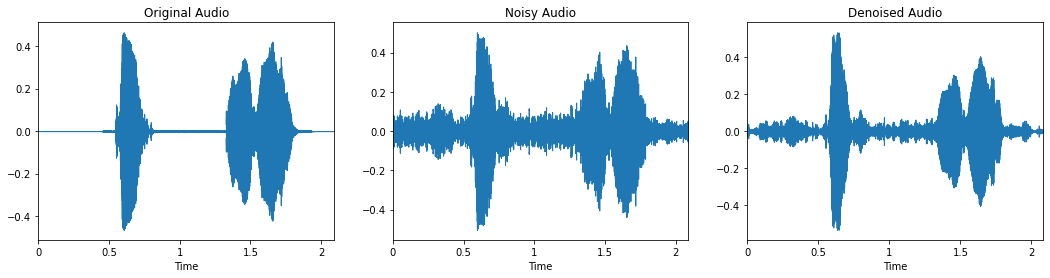

In [ ]:
output = librosa.load("test_s_01_recons.wav", sr=sr)[0]

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
librosa.display.waveplot(x_clean, sr=sr)
plt.title('Original Audio')
plt.subplot(1, 3, 2)
librosa.display.waveplot(x_noisy, sr=sr)
plt.title('Noisy Audio')
plt.subplot(1, 3, 3)
librosa.display.waveplot(output, sr=sr)
plt.title('Denoised Audio')
plt.show()

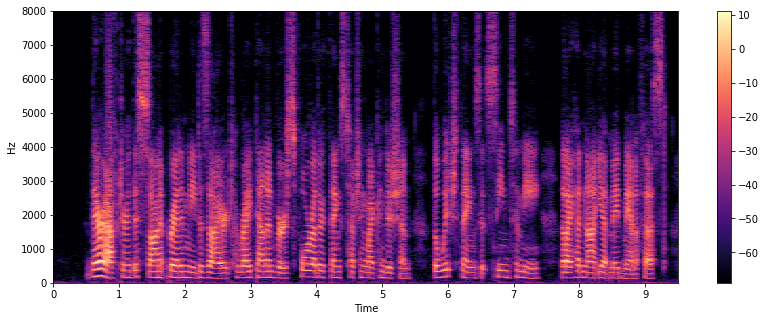

In [ ]:
X_clean = preprocessing.normalize([x_clean])
X_clean = librosa.stft(X_clean[0])
X_clean_db = librosa.amplitude_to_db(np.abs(X_clean))
plt.figure(figsize=(14, 5))
librosa.display.specshow(X_clean_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

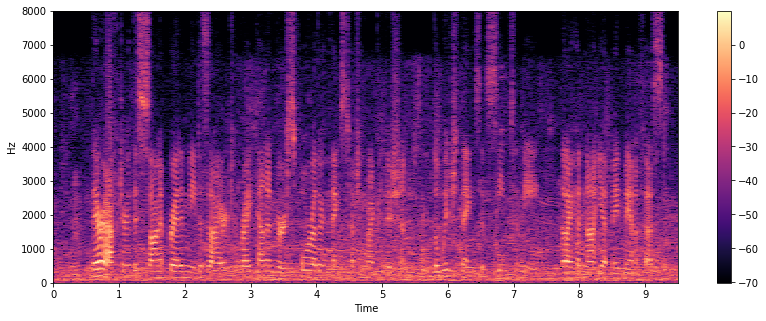

In [ ]:
X_noisy = preprocessing.normalize([x_noisy])
X_noisy = librosa.stft(X_noisy[0])
X_noisy_db = librosa.amplitude_to_db(np.abs(X_noisy))
plt.figure(figsize=(14, 5))
librosa.display.specshow(X_noisy_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

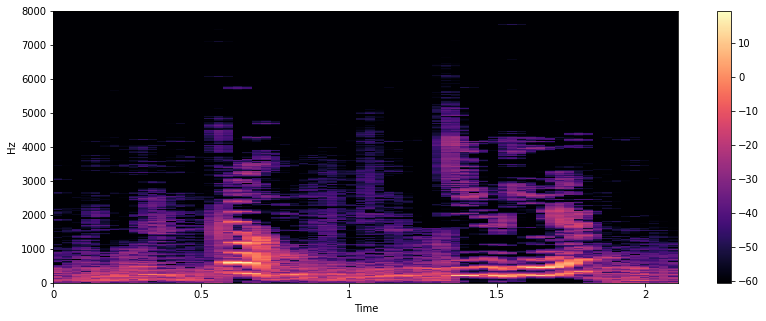

In [ ]:
X_output = preprocessing.normalize([output])
X_output = librosa.stft(X_output[0])
X_output_db = librosa.amplitude_to_db(np.abs(X_output))
plt.figure(figsize=(14, 5))
librosa.display.specshow(X_output_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()